# Code Opti_ADRS

NX=  4  | cost_opt = 3.311e-10  | xopt = [ 1.24574941e+06 -2.97449000e+02  4.61770000e+01 -2.98340000e+01
 -1.45762000e+02  2.92561000e+02]
NX=  8  | cost_opt = 1.938e-11  | xopt = [1.    2.    2.99  4.135 4.66  6.215]
NX= 15  | cost_opt = 1.004e-11  | xopt = [1. 2. 3. 4. 5. 6.]
NX= 30  | cost_opt = 3.891e-08  | xopt = [0.995 1.998 3.005 3.987 5.017 5.992]
NX= 50  | cost_opt = 9.974e-05  | xopt = [0.794 1.883 3.241 3.325 5.908 5.56 ]


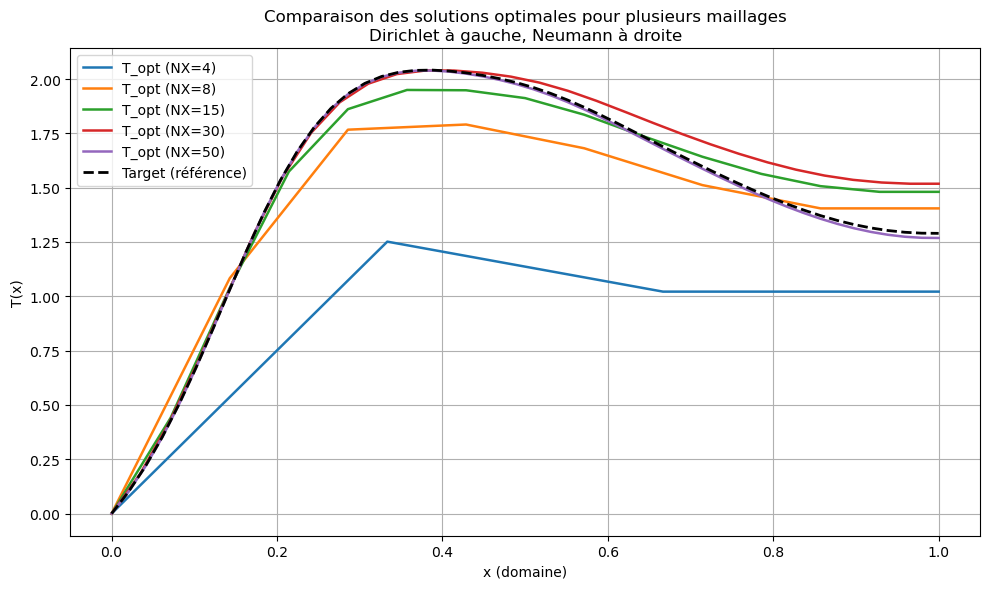

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# ===============  FONCTION ADRS  =============================
# ============================================================

def ADRS(NX, xcontrol, Target):
    """
    Résout une équation ADRS stationnaire :
        -V u_x + K u_xx - lam u + f = 0
    Conditions :
        u(0) = 0          (Dirichlet homogène)
        du/dx(L) = 0      (Neumann homogène)
    """
    # PHYSICAL PARAMETERS
    K = 0.1
    L = 1.0
    Time = 20.
    V = 1
    lamda = 1

    # NUMERICAL PARAMETERS
    NT = 1000
    eps = 0.0001

    dx = L / (NX - 1)
    x = np.linspace(0.0, L, NX)

    # Initialisation
    T = np.zeros(NX)
    F = np.zeros(NX)
    RHS = np.zeros(NX)

    # === Définition de la source ===
    for j in range(1, NX - 1):
        for ic in range(len(xcontrol)):
            F[j] += xcontrol[ic] * np.exp(-100 * (x[j] - L / (ic + 1))**2)

    dt = 0.5 * dx**2 / (V * dx + 2 * K + abs(np.max(F)) * dx**2)

    # === Boucle temporelle ===
    n = 0
    res = 1
    res0 = 1

    while n < NT and res > eps * res0:
        n += 1
        res = 0

        # === BORD GAUCHE : Dirichlet homogène ===
        T[0] = 0.0

        # === BORD DROIT : Neumann homogène ===
        T[-1] = T[-2]

        # === Intérieur ===
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j + 1] - T[j - 1]) / (2 * dx)
            Txx = (T[j - 1] - 2 * T[j] + T[j + 1]) / (dx**2)
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        # Mise à jour
        for j in range(1, NX - 1):
            T[j] += RHS[j]
            RHS[j] = 0.0

        if n == 1:
            res0 = res

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T


# ============================================================
# ===============  OPTIMISATION LINEAIRE  ====================
# ============================================================

def optimize_for_mesh(NX, nbc=6):
    """
    Pour un maillage donné NX :
    - construit la cible,
    - calcule la matrice A et le vecteur B,
    - résout pour obtenir xopt,
    - renvoie la solution optimisée et la cible.
    """
    Target = np.zeros(NX)
    xcible = np.arange(nbc) + 1
    _, Target = ADRS(NX, xcible, Target)

    xcontrol = np.zeros(nbc)
    _, T0 = ADRS(NX, xcontrol, Target)

    A = np.zeros((nbc, nbc))
    B = np.zeros(nbc)

    for ic in range(nbc):
        xic = np.zeros(nbc)
        xic[ic] = 1
        _, Tic = ADRS(NX, xic, Target)
        B[ic] = np.dot((Target - T0), Tic) / (NX - 1)

        for jc in range(0, ic + 1):
            xjc = np.zeros(nbc)
            xjc[jc] = 1
            _, Tjc = ADRS(NX, xjc, Target)
            A[ic, jc] = np.dot(Tic, Tjc) / (NX - 1)

    # symétriser A
    for ic in range(nbc):
        for jc in range(ic, nbc):
            A[ic, jc] = A[jc, ic]

    xopt = np.linalg.solve(A, B)
    cost_opt, T_opt = ADRS(NX, xopt, Target)
    return xopt, cost_opt, T_opt, Target


# ============================================================
# ===============  BOUCLE SUR PLUSIEURS MAILLAGES  ===========
# ============================================================

def main():
    nbc = 6
    NX_list = [4, 8, 15, 30, 50]

    plt.figure(figsize=(10, 6))

    for NX in NX_list:
        xopt, cost_opt, T_opt, Target = optimize_for_mesh(NX, nbc)
        x = np.linspace(0, 1, NX)

        print(f"NX={NX:3d}  | cost_opt = {cost_opt:.3e}  | xopt = {np.round(xopt, 3)}")

        plt.plot(x, T_opt, label=f"T_opt (NX={NX})", linewidth=1.8)
        if NX == NX_list[-1]:
            plt.plot(x, Target, 'k--', label="Target (référence)", linewidth=2)

    plt.xlabel("x (domaine)")
    plt.ylabel("T(x)")
    plt.title("Comparaison des solutions optimales pour plusieurs maillages\nDirichlet à gauche, Neumann à droite")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# ==================  EXECUTION PRINCIPALE  ==================
# ============================================================

if __name__ == "__main__":
    main()


NX=  4  | cost_opt = 1.453e+00  | xopt = [-1.68498829e+08  4.03758350e+04  3.73220970e+04  1.84951623e+06
 -3.88066442e+06 -4.94572175e+06]
NX=  8  | cost_opt = 2.162e-01  | xopt = [ 5.58440000e+01 -2.25983000e+02  4.14716080e+04 -5.66007365e+05
  1.42360979e+06 -8.98018266e+05]
NX= 15  | cost_opt = 5.019e-02  | xopt = [  8.484 -19.032  18.674 -15.873 -28.706  46.307]
NX= 30  | cost_opt = 3.425e-02  | xopt = [  5.72  -19.748  26.204 -43.941  22.693  14.569]
NX= 50  | cost_opt = 3.034e-02  | xopt = [  5.323 -19.485  28.081 -54.136  44.743   0.107]
NX=100  | cost_opt = 4.667e-02  | xopt = [ -2.909 -19.661  38.28  -80.337  87.471 -23.119]
NX=200  | cost_opt = 1.580e-01  | xopt = [ -15.876  -24.67    59.695 -111.576  137.024  -40.684]


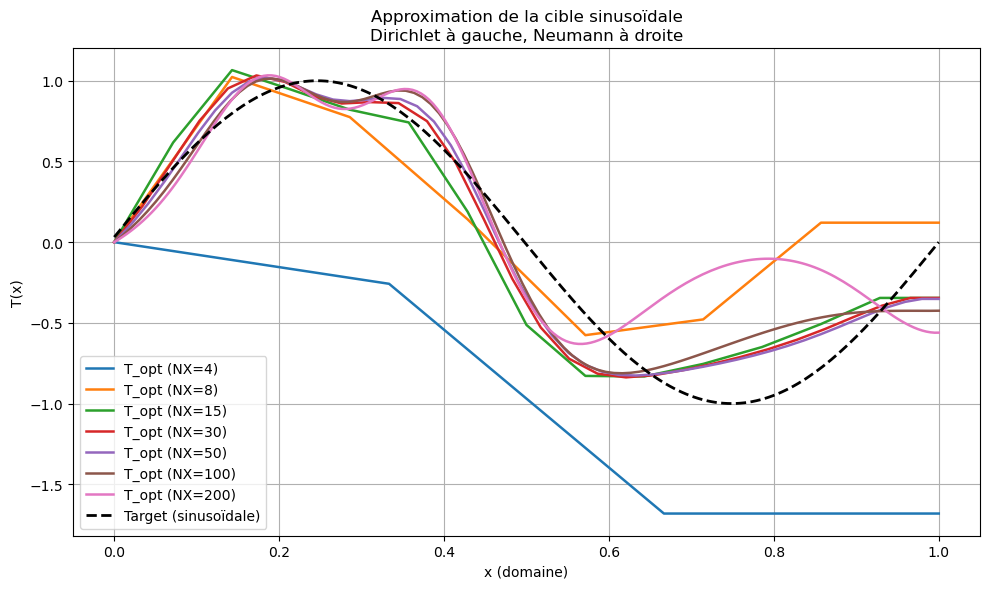

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# ===============  FONCTION ADRS  =============================
# ============================================================

def ADRS(NX, xcontrol, Target):
    """
    Résout une équation ADRS stationnaire :
        -V u_x + K u_xx - lam u + f = 0
    Conditions :
        u(0) = 0          (Dirichlet homogène)
        du/dx(L) = 0      (Neumann homogène)
    """
    # PHYSICAL PARAMETERS
    K = 0.1
    L = 1.0
    Time = 20.
    V = 1
    lamda = 1

    # NUMERICAL PARAMETERS
    NT = 1000
    eps = 0.0001

    dx = L / (NX - 1)
    x = np.linspace(0.0, L, NX)

    # Initialisation
    T = np.zeros(NX)
    F = np.zeros(NX)
    RHS = np.zeros(NX)

    # === Définition de la source ===
    for j in range(1, NX - 1):
        for ic in range(len(xcontrol)):
            F[j] += xcontrol[ic] * np.exp(-100 * (x[j] - L / (ic + 1))**2)

    dt = 0.5 * dx**2 / (V * dx + 2 * K + abs(np.max(F)) * dx**2)

    # === Boucle temporelle ===
    n = 0
    res = 1
    res0 = 1

    while n < NT and res > eps * res0:
        n += 1
        res = 0

        # === BORD GAUCHE : Dirichlet homogène ===
        T[0] = 0.0

        # === BORD DROIT : Neumann homogène ===
        T[-1] = T[-2]

        # === Intérieur ===
        for j in range(1, NX - 1):
            xnu = K + 0.5 * dx * abs(V)
            Tx = (T[j + 1] - T[j - 1]) / (2 * dx)
            Txx = (T[j - 1] - 2 * T[j] + T[j + 1]) / (dx**2)
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + F[j])
            res += abs(RHS[j])

        # Mise à jour
        for j in range(1, NX - 1):
            T[j] += RHS[j]
            RHS[j] = 0.0

        if n == 1:
            res0 = res

    cost = np.dot(T - Target, T - Target) * dx
    return cost, T


# ============================================================
# ===============  OPTIMISATION LINEAIRE  ====================
# ============================================================

def optimize_for_mesh(NX, nbc=6):
    """
    Pour un maillage donné NX :
    - construit la cible sinusoïdale,
    - calcule la matrice A et le vecteur B,
    - résout pour obtenir xopt,
    - renvoie la solution optimisée et la cible.
    """
    # === Définition de la cible sinusoïdale ===
    x = np.linspace(0, 1, NX)
    Target = np.sin(2 * np.pi * (np.arange(NX) + 1) / NX)

    # === Calcul de l'état de base (sans source) ===
    xcontrol = np.zeros(nbc)
    _, T0 = ADRS(NX, xcontrol, Target)

    # === Assemblage de A et B ===
    A = np.zeros((nbc, nbc))
    B = np.zeros(nbc)

    for ic in range(nbc):
        xic = np.zeros(nbc)
        xic[ic] = 1
        _, Tic = ADRS(NX, xic, Target)
        B[ic] = np.dot((Target - T0), Tic) * (1.0 / NX)

        for jc in range(0, ic + 1):
            xjc = np.zeros(nbc)
            xjc[jc] = 1
            _, Tjc = ADRS(NX, xjc, Target)
            A[ic, jc] = np.dot(Tic, Tjc) * (1.0 / NX)

    # Symétrisation
    for ic in range(nbc):
        for jc in range(ic, nbc):
            A[ic, jc] = A[jc, ic]

    # === Résolution linéaire ===
    xopt = np.linalg.solve(A, B)
    cost_opt, T_opt = ADRS(NX, xopt, Target)
    return xopt, cost_opt, T_opt, Target


# ============================================================
# ===============  BOUCLE SUR PLUSIEURS MAILLAGES  ===========
# ============================================================

def main():
    nbc = 6
    NX_list = [4, 8, 15, 30, 50, 100, 200]

    plt.figure(figsize=(10, 6))

    for NX in NX_list:
        xopt, cost_opt, T_opt, Target = optimize_for_mesh(NX, nbc)
        x = np.linspace(0, 1, NX)

        print(f"NX={NX:3d}  | cost_opt = {cost_opt:.3e}  | xopt = {np.round(xopt, 3)}")

        plt.plot(x, T_opt, label=f"T_opt (NX={NX})", linewidth=1.8)
        if NX == NX_list[-1]:
            plt.plot(x, Target, 'k--', label="Target (sinusoïdale)", linewidth=2)

    plt.xlabel("x (domaine)")
    plt.ylabel("T(x)")
    plt.title("Approximation de la cible sinusoïdale\nDirichlet à gauche, Neumann à droite")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# ==================  EXECUTION PRINCIPALE  ==================
# ============================================================

if __name__ == "__main__":
    main()


[Ref fixe] cond(A)≈2.20e+07 | J=1.898e-25 | x*=[1. 2. 3. 4. 5. 6.]
[Adapt] NXs=[40, 50, 60, 70, 80, 90, 100] | cond(A)≈2.12e+07 | J=6.971e-07 | ||x*-Xopt||=1.431e+00 | x*=[0.9758 2.1037 2.5872 4.9271 4.0549 6.3346]
[Adapt] NXs=[60, 80, 100, 120, 140, 160, 180] | cond(A)≈2.20e+07 | J=1.255e-07 | ||x*-Xopt||=7.901e-01 | x*=[0.9894 2.0472 2.7976 4.4877 4.4562 6.2175]
[Adapt] NXs=[90, 110, 130, 150, 170, 190, 210] | cond(A)≈2.20e+07 | J=5.321e-08 | ||x*-Xopt||=5.426e-01 | x*=[0.9929 2.0316 2.8633 4.3326 4.6247 6.1523]


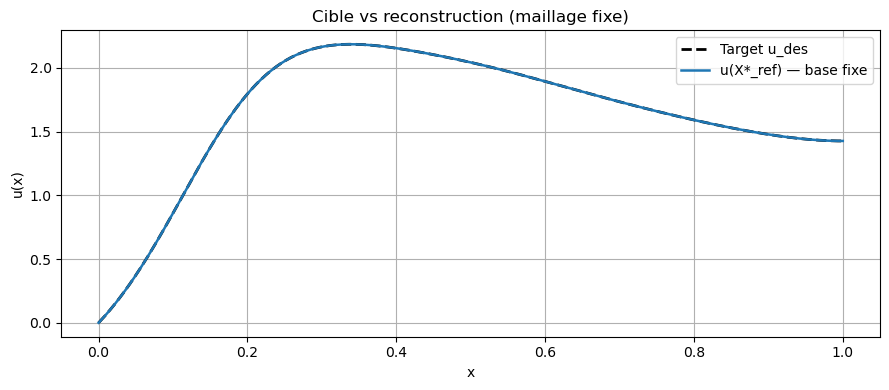

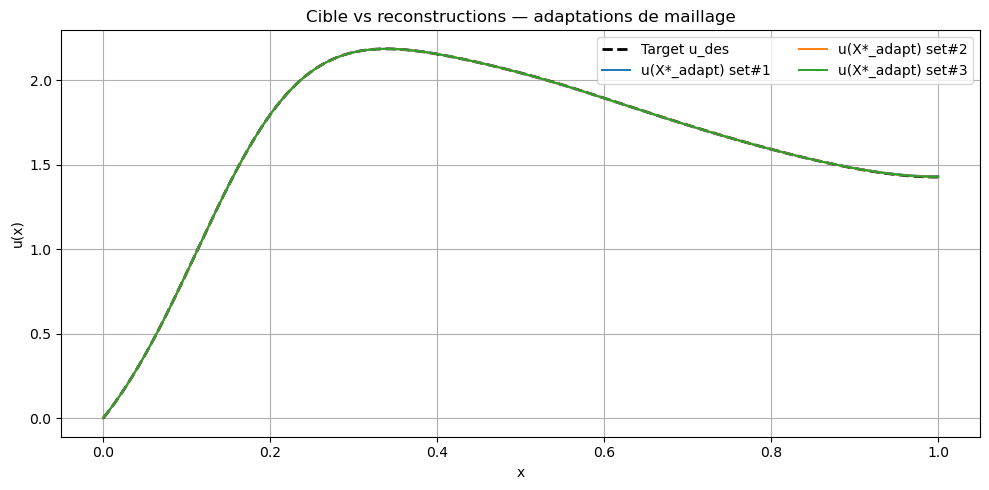

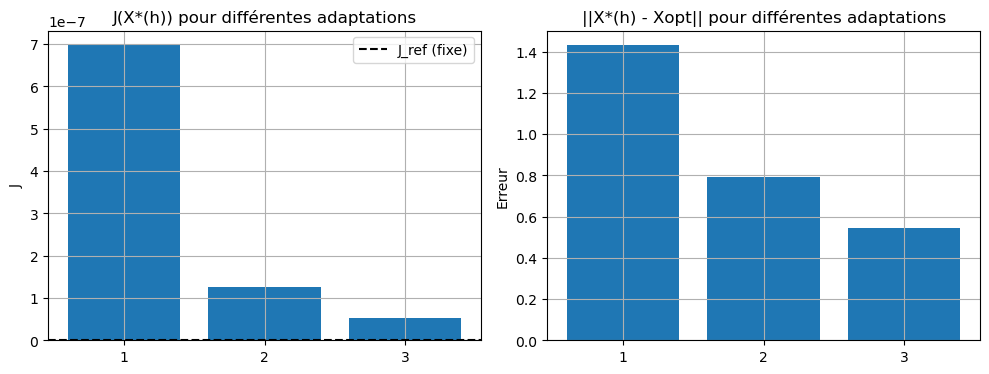

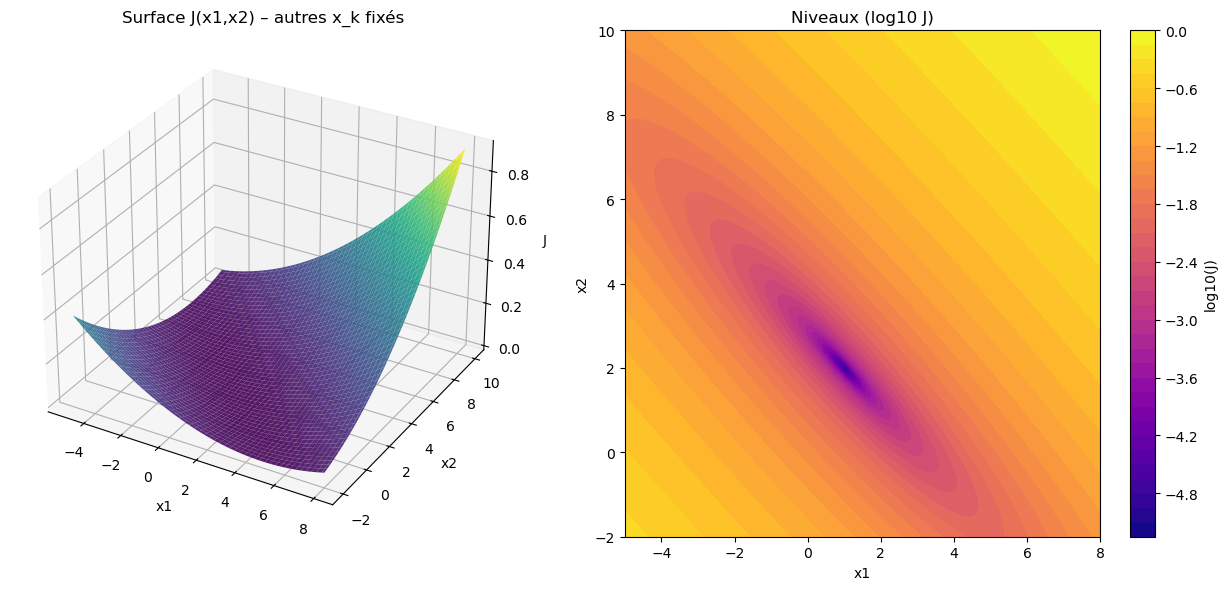

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ============================================================
# =============== 1) SOLVEUR ADRS STATIONNAIRE (D-N) =========
# ============================================================

def solve_ADRS_stationary_DN(NX, alphas, L=1.0, K=0.1, V=1.0, lam=1.0,
                             beta=100.0, source_positions=None):
    """
    Résout:  -V u_x + K u_xx - lam u + f = 0   sur (0,L)
    CL:      u(0)=0 (Dirichlet),   u_x(L)=0 (Neumann homogène)
    f(x) = sum_i alphas[i] * exp(-beta * (x - s_i)^2)
    """
    x = np.linspace(0.0, L, NX)
    if NX < 2:
        return x, np.zeros_like(x)
    dx = x[1] - x[0]
    nbc = len(alphas)

    if source_positions is None:
        source_positions = np.array([L/(i+1) for i in range(1, nbc+1)], dtype=float)

    f = np.zeros_like(x)
    for i, a in enumerate(alphas):
        f += a * np.exp(-beta * (x - source_positions[i])**2)

    n = NX - 2
    if n <= 0:
        u = np.zeros(NX)
        u[-1] = u[-2]
        return x, u

    A = np.zeros((n, n))
    rhs = -f[1:-1]

    a_sub = K/dx**2 + V/(2*dx)
    b_diag = -2*K/dx**2 - lam
    c_sup = K/dx**2 - V/(2*dx)

    np.fill_diagonal(A, b_diag)
    np.fill_diagonal(A[1:], a_sub)
    np.fill_diagonal(A[:, 1:], c_sup)

    # Dirichlet à gauche: u0=0
    # Neumann à droite: u_{N-1} = u_{N-2} -> absorber c_sup dans la dernière diag
    A[-1, -1] += c_sup

    u_inner = np.linalg.solve(A, rhs)
    u = np.zeros(NX)
    u[1:-1] = u_inner
    u[-1] = u[-2]  # Neumann

    return x, u


# ============================================================
# =============== 2) OUTILS: PROJECTION & QUADRATURE =========
# ============================================================

def project_to_reference(x_src, u_src, x_ref):
    return np.interp(x_ref, x_src, u_src)

def trapz_weights_on_ref(x_ref, omega=(0.0, 1.0)):
    a, b = omega
    m = (x_ref >= a) & (x_ref <= b)
    xw = x_ref[m]
    n = xw.size
    if n < 2:
        return xw, np.zeros_like(xw)
    w = np.zeros_like(xw)
    dx = np.diff(xw)
    w[0] = dx[0]/2
    w[-1] = dx[-1]/2
    if n > 2:
        w[1:-1] = (dx[:-1] + dx[1:]) / 2
    return xw, w

def simpson_weights_on_ref(x_ref, omega=(0.0, 1.0)):
    a, b = omega
    m = (x_ref >= a) & (x_ref <= b)
    xw = x_ref[m]
    n = xw.size
    if n < 3 or n % 2 == 0:
        return trapz_weights_on_ref(x_ref, omega)
    h = (xw[-1] - xw[0]) / (n - 1)
    w = np.zeros_like(xw)
    w[0] = w[-1] = h/3
    w[1:-1:2] = 4*h/3
    w[2:-2:2] = 2*h/3
    return xw, w


# ============================================================
# =============== 3) BASE SUR MAILLAGES DIFFERENTS ===========
# ============================================================

def build_basis_on_mixed_meshes(NX_list, nbc, x_ref,
                                L=1.0, K=0.1, V=1.0, lam=1.0, beta=100.0, s_pos=None):
    if s_pos is None:
        s_pos = np.array([L/(i+1) for i in range(1, nbc+1)], dtype=float)

    NX0 = NX_list[0]
    x0, u0 = solve_ADRS_stationary_DN(NX0, np.zeros(nbc), L, K, V, lam, beta, s_pos)
    u0_ref = project_to_reference(x0, u0, x_ref)

    basis_ref = []
    for i in range(nbc):
        NX_i = NX_list[min(i+1, len(NX_list)-1)] if len(NX_list) > 1 else NX0
        alphas = np.zeros(nbc); alphas[i] = 1.0
        xi, ui = solve_ADRS_stationary_DN(NX_i, alphas, L, K, V, lam, beta, s_pos)
        basis_ref.append(project_to_reference(xi, ui, x_ref))
    return u0_ref, np.array(basis_ref)


# ============================================================
# =============== 4) ASSEMBLAGE A,b SUR x_ref ================
# ============================================================

def assemble_on_reference(basis_ref, u0_ref, udes_ref, x_ref, omega=(0.0,1.0), quad="simpson"):
    nbc = basis_ref.shape[0]
    if quad == "simpson":
        xw, w = simpson_weights_on_ref(x_ref, omega)
    else:
        xw, w = trapz_weights_on_ref(x_ref, omega)

    sel = (x_ref >= xw[0]) & (x_ref <= xw[-1])
    Phi = basis_ref[:, sel].T
    y = (udes_ref - u0_ref)[sel]
    sqrtw = np.sqrt(w)[:, None]
    Phi_w = sqrtw * Phi
    y_w = sqrtw[:, 0] * y

    A = Phi_w.T @ Phi_w
    b = Phi_w.T @ y_w
    return A, b, w, Phi, y, sel


def solve_weights(A, b, tikh=None):
    if tikh is not None and tikh > 0:
        n = A.shape[0]
        return np.linalg.solve(A + tikh*np.eye(n), b)
    try:
        return np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        x, *_ = np.linalg.lstsq(A, b, rcond=None)
        return x


def reconstruct_on_ref(u0_ref, basis_ref, xweights):
    return u0_ref + basis_ref.T @ xweights

def cost_on_ref_from_residual(Phi, w, x, y):
    r = Phi @ x - y
    return 0.5 * np.sum(w * r**2)


# ============================================================
# =============== 5) SURFACE J(x1, x2) =======================
# ============================================================

def plot_J_surface_2D(u0_ref, basis_ref, x_ref, udes_ref,
                      omega=(0.0,1.0), idx1=0, idx2=1,
                      grid_x=(-5.0, 8.0, 120), grid_y=(-2.0, 10.0, 120),
                      fixed=None, quad="simpson"):
    nbc = basis_ref.shape[0]
    if fixed is None:
        fixed = np.zeros(nbc)

    if quad == "simpson":
        xw, w = simpson_weights_on_ref(x_ref, omega)
    else:
        xw, w = trapz_weights_on_ref(x_ref, omega)
    sel = (x_ref >= xw[0]) & (x_ref <= xw[-1])

    X = np.linspace(*grid_x)
    Y = np.linspace(*grid_y)
    Z = np.zeros((len(Y), len(X)))

    U0 = u0_ref[sel]
    Phi = basis_ref[:, sel].T
    y = udes_ref[sel]

    for i, x1 in enumerate(X):
        for j, x2 in enumerate(Y):
            xvec = fixed.copy()
            xvec[idx1] = x1
            xvec[idx2] = x2
            r = (U0 + Phi @ xvec) - y
            Z[j, i] = 0.5 * np.sum(w * r**2)

    Xg, Yg = np.meshgrid(X, Y)
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(1,2,1, projection='3d')
    ax.plot_surface(Xg, Yg, Z, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_xlabel(f"x{idx1+1}"); ax.set_ylabel(f"x{idx2+1}"); ax.set_zlabel("J")
    ax.set_title("Surface J(x1,x2) – autres x_k fixés")

    ax2 = fig.add_subplot(1,2,2)
    cs = ax2.contourf(Xg, Yg, np.log10(Z + 1e-12), levels=40, cmap='plasma')
    fig.colorbar(cs, ax=ax2, label="log10(J)")
    ax2.set_xlabel(f"x{idx1+1}"); ax2.set_ylabel(f"x{idx2+1}")
    ax2.set_title("Niveaux (log10 J)")
    plt.tight_layout(); plt.show()


# ============================================================
# =============== 6) DEMO PRINCIPALE AVEC COURBES ============
# ============================================================

def main():
    # Paramètres
    L, K, V, lam = 1.0, 0.1, 1.0, 1.0
    beta = 100.0
    nbc = 6
    s_pos = np.array([L/(i+1) for i in range(1, nbc+1)], dtype=float)
    omega = (0.0, 1.0)

    # Cible: Xopt = [1..6]
    Xopt = np.arange(1, nbc+1, dtype=float)

    # Maillage de référence (affichage + quadrature)
    NX_ref = 601
    x_ref = np.linspace(0.0, L, NX_ref)

    # u_des (calculé et projeté sur x_ref)
    x_tmp, u_target_tmp = solve_ADRS_stationary_DN(300, Xopt, L, K, V, lam, beta, s_pos)
    udes_ref = project_to_reference(x_tmp, u_target_tmp, x_ref)

    # ---------- Référence “maillage fixe” ----------
    u0_fix, basis_fix = build_basis_on_mixed_meshes([300] + [300]*nbc, nbc, x_ref,
                                                    L, K, V, lam, beta, s_pos)
    A_fix, b_fix, w_fix, Phi_fix, y_fix, sel_fix = assemble_on_reference(
        basis_fix, u0_fix, udes_ref, x_ref, omega, quad="simpson"
    )
    cond_fix = np.linalg.cond(A_fix)
    tikh_fix = 0.0
    if cond_fix > 1e10:
        tikh_fix = 1e-10 * np.trace(A_fix) / A_fix.shape[0]
    xstar_fix = solve_weights(A_fix, b_fix, tikh=tikh_fix)
    urec_fix = reconstruct_on_ref(u0_fix, basis_fix, xstar_fix)
    J_fix = cost_on_ref_from_residual(Phi_fix, w_fix, xstar_fix, y_fix)
    print(f"[Ref fixe] cond(A)≈{cond_fix:.2e} | J={J_fix:.3e} | x*={np.round(xstar_fix,4)}")

    # ---------- Adaptations (maillages différents) ----------
    NX_sets = [
        [40, 50, 60, 70, 80, 90, 100],
        [60, 80, 100, 120, 140, 160, 180],
        [90, 110, 130, 150, 170, 190, 210],
    ]

    errs, Js, tags, urec_list = [], [], [], []

    for NX_list in NX_sets:
        u0_ad, basis_ad = build_basis_on_mixed_meshes(NX_list, nbc, x_ref, L, K, V, lam, beta, s_pos)
        A_ad, b_ad, w_ad, Phi_ad, y_ad, sel_ad = assemble_on_reference(
            basis_ad, u0_ad, udes_ref, x_ref, omega, quad="simpson"
        )
        cond_ad = np.linalg.cond(A_ad)
        tikh = 0.0
        if cond_ad > 1e10:
            tikh = 1e-10 * np.trace(A_ad) / A_ad.shape[0]
        xstar_ad = solve_weights(A_ad, b_ad, tikh=tikh)
        urec_ad = reconstruct_on_ref(u0_ad, basis_ad, xstar_ad)
        J_ad = cost_on_ref_from_residual(Phi_ad, w_ad, xstar_ad, y_ad)
        err = np.linalg.norm(xstar_ad - Xopt)

        tags.append(f"{NX_list}")
        errs.append(err)
        Js.append(J_ad)
        urec_list.append(urec_ad)

        print(f"[Adapt] NXs={NX_list} | cond(A)≈{cond_ad:.2e} | J={J_ad:.3e} | ||x*-Xopt||={err:.3e} | x*={np.round(xstar_ad,4)}")

    # ---------- TRAÇAGE DES FONCTIONS ----------
    # 1) Cible vs reconstruction sur maillage fixe
    plt.figure(figsize=(9,4))
    plt.plot(x_ref, udes_ref, 'k--', lw=2, label="Target u_des")
    plt.plot(x_ref, urec_fix, lw=1.8, label="u(X*_ref) — base fixe")
    plt.xlabel("x"); plt.ylabel("u(x)")
    plt.title("Cible vs reconstruction (maillage fixe)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # 2) Cible vs toutes les reconstructions adaptées (projetées sur x_ref)
    plt.figure(figsize=(10,5))
    plt.plot(x_ref, udes_ref, 'k--', lw=2, label="Target u_des")
    for i, urec_ad in enumerate(urec_list):
        plt.plot(x_ref, urec_ad, lw=1.4, label=f"u(X*_adapt) set#{i+1}")
    plt.xlabel("x"); plt.ylabel("u(x)")
    plt.title("Cible vs reconstructions — adaptations de maillage")
    plt.grid(True); plt.legend(ncol=2); plt.tight_layout(); plt.show()

    # ---------- Tracés convergence chiffres ----------
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(range(len(Js)), Js, tick_label=[f"{i+1}" for i in range(len(Js))])
    plt.axhline(J_fix, color='k', linestyle='--', label='J_ref (fixe)')
    plt.title("J(X*(h)) pour différentes adaptations")
    plt.ylabel("J"); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.bar(range(len(errs)), errs, tick_label=[f"{i+1}" for i in range(len(errs))])
    plt.title("||X*(h) - Xopt|| pour différentes adaptations")
    plt.ylabel("Erreur"); plt.grid(True)
    plt.tight_layout(); plt.show()

    # ---------- Surface J(x1,x2) (autres x_k fixés à x*_ref) ----------
    fixed = xstar_fix.copy()
    plot_J_surface_2D(u0_fix, basis_fix, x_ref, udes_ref,
                      omega=omega, idx1=0, idx2=1,
                      grid_x=(-5.0, 8.0, 100), grid_y=(-2.0, 10.0, 100),
                      fixed=fixed, quad="simpson")


if __name__ == "__main__":
    main()


### Description des expériences

Le script ci-dessous réalise **deux expériences distinctes**.

---

#### 🔹 Cas “vérité connue”

On définit la solution de référence :

$X_{\text{opt}} = (1, 2, 3, 4)$

puis on calcule :

$u_{\text{des}} = u(X_{\text{opt}})$

À partir de cette solution de référence, on reconstitue $X^*(h)$ en résolvant le système linéaire :

$A x = b$

pour plusieurs tailles de maillage $N_X$.

Les graphiques produits représentent :

- chaque **composante** de $X^*(h)$ en fonction de $N_X$ ;
- le **coût fonctionnel** $J(X^*(h))$ en fonction de $N_X$ ;
- l’**erreur** $\| X^*(h) - X_{\text{opt}} \|$ en fonction de $N_X$.

---

#### 🔹 Cas “$u_{\text{des}} = 1$” (constante)

On fixe une cible uniforme :

$u_{\text{des}}(x) = 1$

et on cherche le meilleur contrôle $X^*(h)$ qui permet d’approcher cette cible.

Les graphiques produits montrent :

- le **coût fonctionnel** $J(X^*(h))$ en fonction du maillage $N_X$ ;
- l’**évolution de chaque composante** de $X^*(h)$ en fonction de $N_X$.

---

#### 🔸 Solveur direct

Le solveur direct est **stationnaire** (pas de boucle en temps) et utilise les conditions aux limites suivantes :

- **Dirichlet homogène** à gauche : $u(0) = 0$  
- **Neumann homogène** à droite : $u_x(L) = 0$

Les produits scalaires $\langle \cdot, \cdot \rangle_{L^2}$ sont calculés de manière cohérente avec la discrétisation, en tenant compte du pas spatial $dx$.


[Known] NX=  20 | J=5.675e-30 | ||X*-Xopt||=1.657e-12 | X*=[1. 2. 3. 4.]
[Known] NX=  40 | J=5.752e-31 | ||X*-Xopt||=4.076e-13 | X*=[1. 2. 3. 4.]
[Known] NX=  80 | J=1.482e-31 | ||X*-Xopt||=4.011e-14 | X*=[1. 2. 3. 4.]
[Known] NX= 120 | J=3.284e-29 | ||X*-Xopt||=4.493e-12 | X*=[1. 2. 3. 4.]
[Known] NX= 200 | J=1.494e-29 | ||X*-Xopt||=2.974e-12 | X*=[1. 2. 3. 4.]


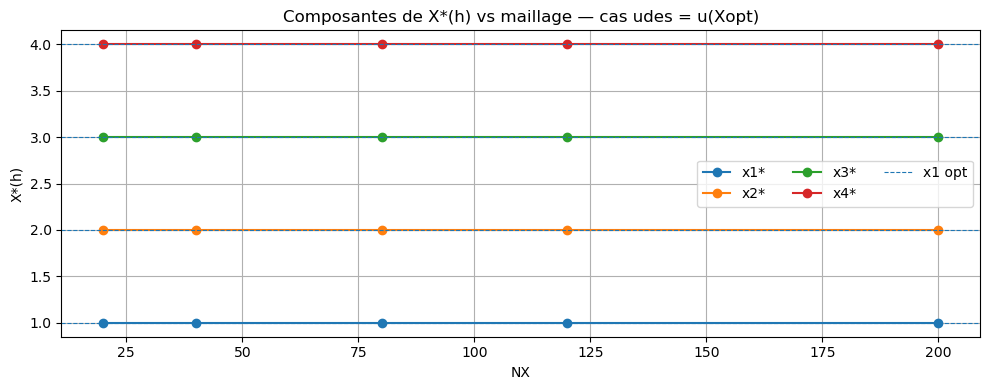

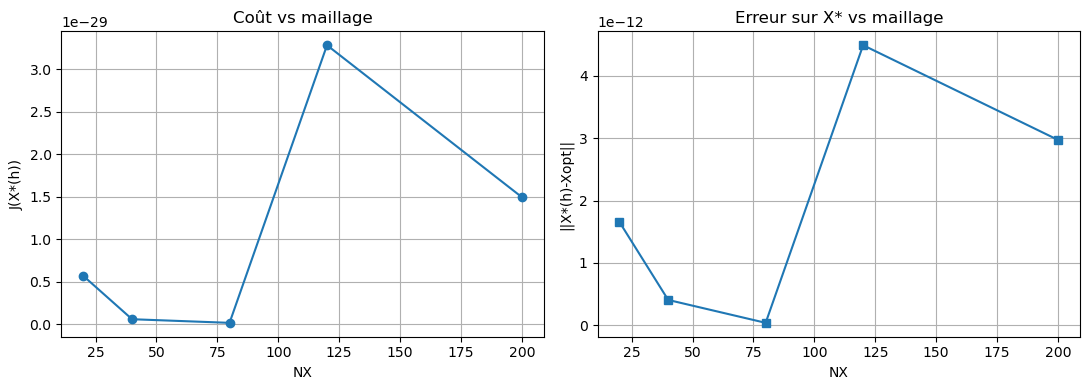

[Const1] NX=  20 | J=4.416e-02 | X*=[  2.1381  13.0622 -47.5746  45.4872]
[Const1] NX=  40 | J=3.595e-02 | X*=[  1.9988  14.7467 -52.5603  49.1629]
[Const1] NX=  80 | J=3.234e-02 | X*=[  1.9515  15.1889 -53.8192  50.0793]
[Const1] NX= 120 | J=3.121e-02 | X*=[  1.9394  15.2766 -54.0583  50.2512]
[Const1] NX= 200 | J=3.033e-02 | X*=[  1.931   15.3255 -54.186   50.3418]


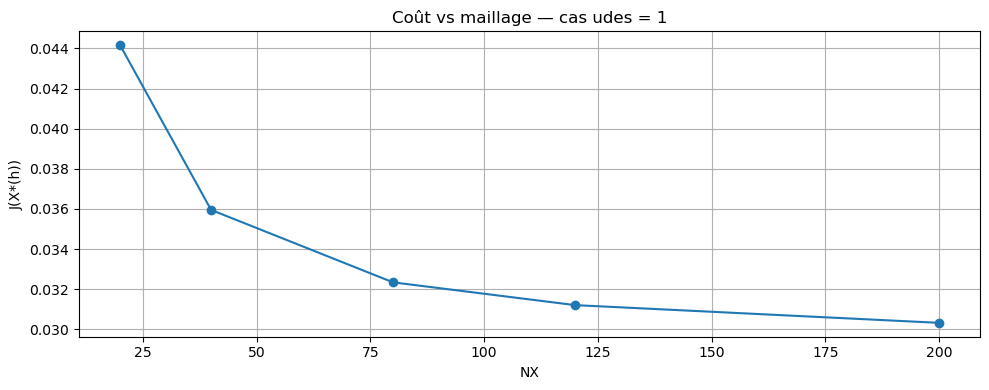

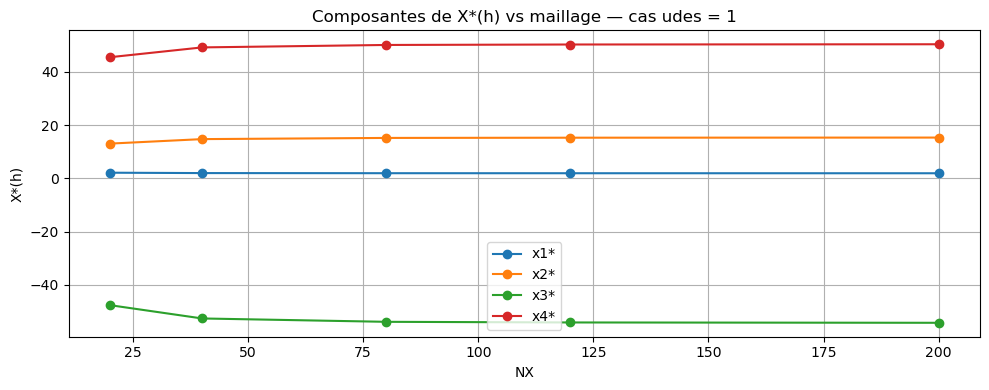

[Check fin] J = 1.494e-29 | ||X*-Xopt|| = 2.974e-12


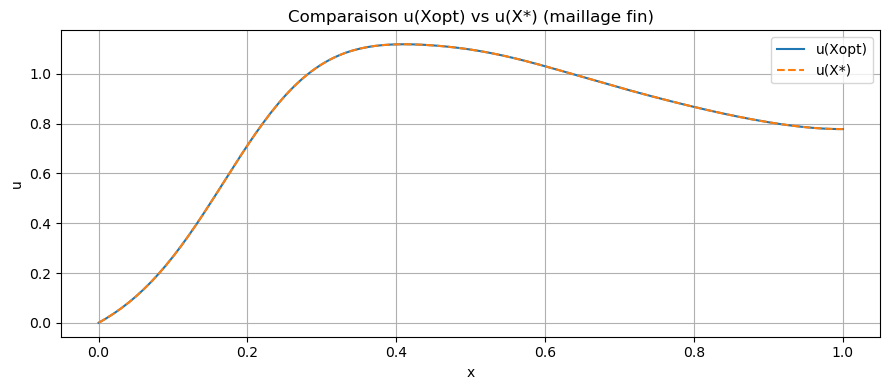

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# ===============  SOLVEUR ADRS STATIONNAIRE (DN) ============
# ============================================================

def solve_ADRS_stationary_DN(NX, alphas, L=1.0, K=0.1, V=1.0, lam=1.0,
                             beta=100.0, source_positions=None):
    """
    -V u_x + K u_xx - lam u + f = 0  sur (0,L)
    BC: u(0)=0 (Dirichlet),  u_x(L)=0 (Neumann homogène)
    f(x) = sum_i alphas[i] * exp(-beta * (x - s_i)^2)
    """
    x = np.linspace(0.0, L, NX)
    dx = x[1] - x[0]
    nbc = len(alphas)

    if source_positions is None:
        # même choix que dans tes scripts précédents
        source_positions = np.array([L/(i+1) for i in range(1, nbc+1)], dtype=float)

    # source
    f = np.zeros_like(x)
    for i, a in enumerate(alphas):
        f += a * np.exp(-beta * (x - source_positions[i])**2)

    # inconnues: u[1..NX-2] (on élimine u0=0, et u_{N-1} via Neumann)
    n = NX - 2
    if n <= 0:
        # maillage trop petit
        return x, np.zeros_like(x)

    A = np.zeros((n, n))
    rhs = -f[1:-1]  # RHS de la PDE

    a_sub = K/dx**2 + V/(2*dx)
    b_diag = -2*K/dx**2 - lam
    c_sup = K/dx**2 - V/(2*dx)

    # remplir tridiagonale "standard"
    np.fill_diagonal(A, b_diag)
    np.fill_diagonal(A[1:], a_sub)
    np.fill_diagonal(A[:, 1:], c_sup)

    # Dirichlet à gauche: u0=0 -> terme a_sub*u0 sur la 1ère ligne ---> rien à ajouter (u0=0)
    # Neumann à droite: u_{N-1} = u_{N-2} => dernière équation (ligne n-1, j=NX-2) : + c_sup * u_{N-2}
    A[-1, -1] += c_sup  # on absorbe u_{N-1} dans la diagonale

    # résoudre
    u_inner = np.linalg.solve(A, rhs)

    # reconstruire u
    u = np.zeros(NX)
    u[1:-1] = u_inner
    # Neumann à droite : u_{N-1} = u_{N-2}
    u[-1] = u[-2]

    return x, u

# ============================================================
# ===============  OUTILS PRODUITS / ASSEMBLAGES ============
# ============================================================

def build_basis_via_ADRS(NX, nbc, L=1.0, K=0.1, V=1.0, lam=1.0, beta=100.0, s_pos=None):
    if s_pos is None:
        s_pos = np.array([L/(i+1) for i in range(1, nbc+1)], dtype=float)
    x, u0 = solve_ADRS_stationary_DN(NX, np.zeros(nbc), L, K, V, lam, beta, s_pos)
    basis = []
    for i in range(nbc):
        alphas = np.zeros(nbc); alphas[i] = 1.0
        _, ui = solve_ADRS_stationary_DN(NX, alphas, L, K, V, lam, beta, s_pos)
        basis.append(ui)
    basis = np.array(basis)  # (nbc, NX)
    return x, u0, basis

def assemble_A_b(basis, u0, udes, dx):
    """
    A_ij = <u_i, u_j>_L2  ;  b_i = <u_i, (udes - u0)>_L2
    """
    nbc, NX = basis.shape
    A = np.zeros((nbc, nbc))
    b = np.zeros(nbc)
    rhs = udes - u0
    for i in range(nbc):
        ui = basis[i]
        b[i] = dx * np.dot(ui, rhs)
        for j in range(i, nbc):
            Aij = dx * np.dot(ui, basis[j])
            A[i, j] = A[j, i] = Aij
    return A, b

def reconstruct_from_basis(u0, basis, xweights):
    return u0 + basis.T @ xweights

def J_cost(u, udes, dx):
    r = u - udes
    return 0.5 * dx * np.dot(r, r)

# ============================================================
# ======================  EXPÉRIMENTS  =======================
# ============================================================

def experiment_known_truth(NX_list, Xopt, nbc=4, L=1.0, K=0.1, V=1.0, lam=1.0, beta=100.0):
    """
    udes = u(Xopt). Boucle de raffinement en maillage.
    Renvoie dict avec X*(h), J(X*(h)) et ||X*(h)-Xopt||.
    """
    Xstars = []
    Jvals = []
    errs = []

    for NX in NX_list:
        # cible
        x, udes = solve_ADRS_stationary_DN(NX, Xopt, L, K, V, lam, beta)

        # base
        xg, u0, basis = build_basis_via_ADRS(NX, nbc, L, K, V, lam, beta)
        dx = xg[1] - xg[0]

        # assemblage
        A, b = assemble_A_b(basis, u0, udes, dx)

        # solve
        try:
            xstar = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            xstar, *_ = np.linalg.lstsq(A, b, rcond=None)

        urec = reconstruct_from_basis(u0, basis, xstar)
        Jval = J_cost(urec, udes, dx)
        err = np.linalg.norm(xstar - Xopt)

        Xstars.append(xstar)
        Jvals.append(Jval)
        errs.append(err)

        print(f"[Known] NX={NX:4d} | J={Jval:.3e} | ||X*-Xopt||={err:.3e} | X*={np.round(xstar,4)}")

    return {
        "NX": NX_list,
        "Xstars": np.array(Xstars),
        "J": np.array(Jvals),
        "err": np.array(errs),
    }

def experiment_udes_one(NX_list, nbc=4, L=1.0, K=0.1, V=1.0, lam=1.0, beta=100.0):
    """
    udes ≡ 1. Boucle en maillage, trace J(X*(h)) et les composantes de X*(h).
    """
    Xstars = []
    Jvals = []

    for NX in NX_list:
        xg = np.linspace(0.0, L, NX)
        udes = np.ones_like(xg)  # cible constante 1

        xg, u0, basis = build_basis_via_ADRS(NX, nbc, L, K, V, lam, beta)
        dx = xg[1] - xg[0]

        A, b = assemble_A_b(basis, u0, udes, dx)

        try:
            xstar = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            xstar, *_ = np.linalg.lstsq(A, b, rcond=None)

        urec = reconstruct_from_basis(u0, basis, xstar)
        Jval = J_cost(urec, udes, dx)

        Xstars.append(xstar)
        Jvals.append(Jval)
        print(f"[Const1] NX={NX:4d} | J={Jval:.3e} | X*={np.round(xstar,4)}")

    return {
        "NX": NX_list,
        "Xstars": np.array(Xstars),
        "J": np.array(Jvals),
    }

# ============================================================
# =========================  MAIN  ===========================
# ============================================================

def main():
    # --- Paramètres physiques et numériques ---
    L, K, V, lam = 1.0, 0.1, 1.0, 1.0
    beta = 100.0

    # --- Raffinement ---
    NX_list = [20, 40, 80, 120, 200]

    # ============== Cas 1 : udes = u(Xopt) ===================
    nbc = 4
    Xopt = np.array([1.0, 2.0, 3.0, 4.0])  # R^4

    res_known = experiment_known_truth(
        NX_list, Xopt, nbc=nbc, L=L, K=K, V=V, lam=lam, beta=beta
    )

    # Tracés : composantes de X*(h)
    plt.figure(figsize=(10,4))
    for k in range(nbc):
        plt.plot(res_known["NX"], res_known["Xstars"][:,k], "o-", label=f"x{k+1}*")
    for k, val in enumerate(Xopt):
        plt.axhline(val, linestyle="--", linewidth=0.8, label=f"x{k+1} opt" if k==0 else None)
    plt.xlabel("NX")
    plt.ylabel("X*(h)")
    plt.title("Composantes de X*(h) vs maillage — cas udes = u(Xopt)")
    plt.grid(True); plt.legend(ncol=3)
    plt.tight_layout(); plt.show()

    # Tracés : J(X*(h)) et ||X*(h)-Xopt||
    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(res_known["NX"], res_known["J"], "o-")
    ax[0].set_xlabel("NX"); ax[0].set_ylabel("J(X*(h))"); ax[0].set_title("Coût vs maillage")
    ax[0].grid(True)

    ax[1].plot(res_known["NX"], res_known["err"], "s-")
    ax[1].set_xlabel("NX"); ax[1].set_ylabel("||X*(h)-Xopt||"); ax[1].set_title("Erreur sur X* vs maillage")
    ax[1].grid(True)
    plt.tight_layout(); plt.show()

    # ============== Cas 2 : udes = 1 (constante) =============
    nbc2 = 4
    res_const = experiment_udes_one(
        NX_list, nbc=nbc2, L=L, K=K, V=V, lam=lam, beta=beta
    )

    # Tracés : J(X*(h)) et composantes
    plt.figure(figsize=(10,4))
    plt.plot(res_const["NX"], res_const["J"], "o-")
    plt.xlabel("NX"); plt.ylabel("J(X*(h))")
    plt.title("Coût vs maillage — cas udes = 1")
    plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    for k in range(nbc2):
        plt.plot(res_const["NX"], res_const["Xstars"][:,k], "o-", label=f"x{k+1}*")
    plt.xlabel("NX"); plt.ylabel("X*(h)")
    plt.title("Composantes de X*(h) vs maillage — cas udes = 1")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

    # ============== Vérification pointée : u(X*) ≈ udes ======
    # sur le maillage le plus fin du cas 1
    NXf = NX_list[-1]
    xg, udes_fin = solve_ADRS_stationary_DN(NXf, Xopt, L, K, V, lam, beta)
    _, u0f, basisf = build_basis_via_ADRS(NXf, len(Xopt), L, K, V, lam, beta)
    xstar_fin = res_known["Xstars"][-1]
    urec_fin = reconstruct_from_basis(u0f, basisf, xstar_fin)
    dx = xg[1]-xg[0]
    print(f"[Check fin] J = {J_cost(urec_fin, udes_fin, dx):.3e} | ||X*-Xopt|| = {np.linalg.norm(xstar_fin-Xopt):.3e}")

    plt.figure(figsize=(9,4))
    plt.plot(xg, udes_fin, label="u(Xopt)")
    plt.plot(xg, urec_fin, "--", label="u(X*)")
    plt.xlabel("x"); plt.ylabel("u")
    plt.title("Comparaison u(Xopt) vs u(X*) (maillage fin)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


if __name__ == "__main__":
    main()
